In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam

# Generate synthetic stock data (replace with your dataset)
np.random.seed(42)
num_samples = 1000
closing_prices = np.sin(np.linspace(0, 20, num_samples)) + np.random.normal(0, 0.1, num_samples)
dates = pd.date_range(start="2020-01-01", periods=num_samples, freq="D")
data = pd.DataFrame({"ds": dates, "y": closing_prices})

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data["y"].values.reshape(-1, 1))

# Prepare data for CNN-LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30  # Use last 30 days to predict the next value
X, y = create_sequences(scaled_data, sequence_length)


ImportError: cannot import name 'animation' from partially initialized module 'matplotlib' (most likely due to a circular import) (C:\Users\Arindam\anaconda3\lib\site-packages\matplotlib\__init__.py)

Epoch 1/20
25/25 [==============================] - 3s 30ms/step - loss: 0.0907 - val_loss: 0.0167
Epoch 2/20
25/25 [==============================] - 0s 10ms/step - loss: 0.0116 - val_loss: 0.0058
Epoch 3/20
25/25 [==============================] - 0s 12ms/step - loss: 0.0062 - val_loss: 0.0042
Epoch 4/20
25/25 [==============================] - 0s 13ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 5/20
25/25 [==============================] - 0s 13ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 6/20
25/25 [==============================] - 0s 13ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 7/20
25/25 [==============================] - 0s 13ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 8/20
25/25 [==============================] - 0s 13ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 9/20
25/25 [==============================] - 0s 14ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 10/20
25/25 [==============================] - 0s 13ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 11/

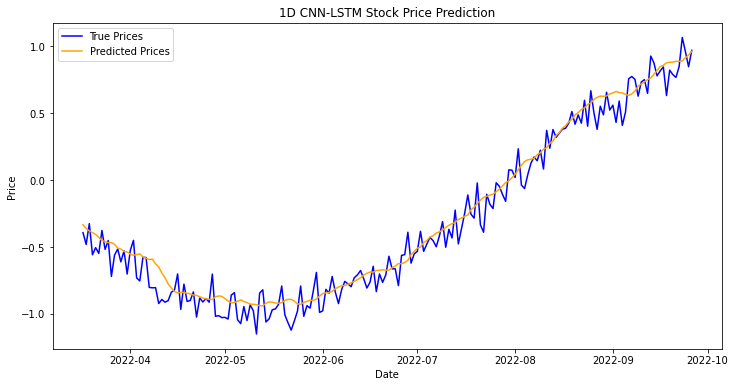

In [3]:

# Split into train and test sets
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape X for CNN-LSTM (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build 1D CNN-LSTM model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss}, Test Loss: {test_loss}")

# Make predictions
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)  # Convert back to original scale
y_test_rescaled = scaler.inverse_transform(y_test)  # Convert back to original scale

# Calculate MSE
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
print(f"Mean Squared Error: {mse}")

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(data["ds"].iloc[-len(y_test_rescaled):], y_test_rescaled, label="True Prices", color='blue')
plt.plot(data["ds"].iloc[-len(y_test_rescaled):], predictions_rescaled, label="Predicted Prices", color='orange')
plt.title("1D CNN-LSTM Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()